# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dfset has been stored in the file `data/C2A2_df/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : df value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 df for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import mplleaflet
import datetime
import pandas as pd
import numpy as np


def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [2]:
# Let's get some information about the dfset

data = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
ID            165085 non-null object
Date          165085 non-null object
Element       165085 non-null object
Data_Value    165085 non-null int64
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


In [3]:
# Convert all data to degrees Celsius:

data['Data_Value'] = data['Data_Value']/10

data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month_Day'] = data['Date'].dt.strftime('%m-%d')

# Remove February 29:
data = data[data['Month_Day']!='02-29']

data.head()

,ID,Date,Element,Data_Value,Year,Month_Day
0,USW00094889,2014-11-12,TMAX,2.2,2014,11-12
1,USC00208972,2009-04-29,TMIN,5.6,2009,04-29
2,USC00200032,2008-05-26,TMAX,27.8,2008,05-26
3,USC00205563,2005-11-11,TMAX,13.9,2005,11-11
4,USC00200230,2014-02-27,TMAX,-10.6,2014,02-27


In [4]:
# Max and min data after grouping by 'Month_Day'

max_temp = data[(data.Year >= 2005) & (data.Year < 2015) & 
                (data['Element'] == 'TMAX')].groupby(['Month_Day'])['Data_Value'].max()
min_temp = data[(data.Year >= 2005) & (data.Year < 2015) & 
                (data['Element'] == 'TMIN')].groupby(['Month_Day'])['Data_Value'].min()
max_temp.head()

Month_Day
01-01    15.6
01-02    13.9
01-03    13.3
01-04    10.6
01-05    12.8
Name: Data_Value, dtype: float64

In [5]:
# Add 'max_temp' and 'min_temp' columns to 'data' dataframe

data = data.merge(max_temp.reset_index(drop=False).rename(columns={'Data_Value':'Max_temp'}), 
                  on='Month_Day', how='left')
data = data.merge(min_temp.reset_index(drop=False).rename(columns={'Data_Value':'Min_temp'}),
                  on='Month_Day', how='left')
data.head()

,ID,Date,Element,Data_Value,Year,Month_Day,Max_temp,Min_temp
0,USW00094889,2014-11-12,TMAX,2.2,2014,11-12,21.1,-9.4
1,USC00208972,2009-04-29,TMIN,5.6,2009,04-29,27.2,-5.0
2,USC00200032,2008-05-26,TMAX,27.8,2008,05-26,33.3,-1.0
3,USC00205563,2005-11-11,TMAX,13.9,2005,11-11,22.2,-7.7
4,USC00200230,2014-02-27,TMAX,-10.6,2014,02-27,12.2,-23.8


In [6]:
# Get record high and low temps in 2015

record_high = data[(data.Year==2015)&(data.Data_Value > data.Max_temp)]
record_low = data[(data.Year==2015)&(data.Data_Value < data.Min_temp)]

record_high.head()

,ID,Date,Element,Data_Value,Year,Month_Day,Max_temp,Min_temp
507,USC00200228,2015-12-13,TMAX,16.7,2015,12-13,11.1,-17.8
669,USC00201250,2015-12-23,TMAX,16.7,2015,12-23,13.3,-20.0
2199,USW00014833,2015-12-13,TMIN,13.9,2015,12-13,11.1,-17.8
2266,USW00014833,2015-12-13,TMAX,16.1,2015,12-13,11.1,-17.8
4382,USC00202308,2015-12-13,TMAX,17.8,2015,12-13,11.1,-17.8


In [7]:
# Get full date representation for 'Month_Day' column

date_index = np.arange('2015-01-01','2016-01-01', dtype='datetime64[D]')
date_index[:31]

array(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
       '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
       '2015-01-09', '2015-01-10', '2015-01-11', '2015-01-12',
       '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16',
       '2015-01-17', '2015-01-18', '2015-01-19', '2015-01-20',
       '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24',
       '2015-01-25', '2015-01-26', '2015-01-27', '2015-01-28',
       '2015-01-29', '2015-01-30', '2015-01-31'], dtype='datetime64[D]')

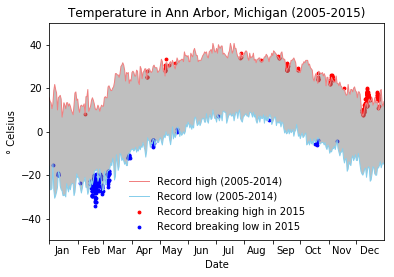

In [8]:
plt.figure()

plt.plot(date_index,max_temp,color='lightcoral', linewidth=1) # Max in red.
plt.plot(date_index,min_temp,color='skyblue', linewidth=1) # Min in blue.

plt.scatter(record_high.Date.values, record_high.Data_Value.values, color='red', s=8)
plt.scatter(record_low.Date.values, record_low.Data_Value.values, color='blue', s=8)

# Set x and y limits.
ax = plt.gca()
ax.axis(['2015/01/01','2015/12/31',-50,50])

# Set axis names and title:
plt.xlabel('Date', fontsize=10)
plt.ylabel('° Celsius', fontsize=10)
plt.title('Temperature in Ann Arbor, Michigan (2005-2015)', fontsize=12)

# Create legend and title
# loc=0 provides the best position for the legend
plt.legend(['Record high (2005-2014)','Record low (2005-2014)','Record breaking high in 2015','Record breaking low in 2015'],loc=0,frameon=False)

# Fill color between highs and lows: alpha adjusts darkness of the shade.
ax.fill_between(date_index, max_temp, min_temp, facecolor='grey', alpha=0.5)

# Locate the major and minor ticks:
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15)) # Put the label at the minor tick so it's in the center.
#ax.yaxis.set_minor_locator()

# Determine what we put at the ticks:
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# 1 refers to the bottom of the plot for xticks and the left for yticks
# 2 refers to the top of the plot for xticks and the right for yticks
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0) # Make small ticker disappear
    tick.label1.set_horizontalalignment('center')
    
plt.show()
